In [6]:
import numpy as np
import pandas as pd
from py_dss_interface import DSSDLL
import matplotlib.pyplot as plt
import csv

# Initialize OpenDSS
dss = DSSDLL(r"C:\Program Files\OpenDSS")
dss_file = r"D:\Aspen_Airport\Aspen_Airport\Master_qsts_2020.dss"
dss.text(f"compile [{dss_file}]")


# Volt-Var Attack Simulation
X10, X20, X30, X40, X50 = 0.5, 0.92, 1.0, 1.08, 1.50


DELTA, MAX_CHANGE = 0.1, 0.1
ROUNDS = 100000
avg = [0] * ROUNDS

def make_stealthy_changes(X, delta=DELTA, max_change=MAX_CHANGE):
    new_values = [0] * len(X)
    for idx, xi0 in enumerate([X10, X20, X30, X40, X50]):
        # Generate the change
        d = np.random.normal(-delta, delta)
        new_value = X[idx] + d
        
        # Clip the new_value to ensure it's within bounds
        new_value = np.clip(new_value, xi0 - max_change, xi0 + max_change)
        
        # If this isn't the first value, ensure it's greater than the last
        if idx > 0:
            new_value = max(new_value, new_values[idx-1] + 0.01)  # The 0.01 ensures a slight gap
        
        new_values[idx] = new_value
    return new_values


with open("attack_points_aspen.csv", "w", newline="") as attack_file, open("non_attack_points_aspen.csv", "w", newline="") as non_attack_file:
    attack_writer = csv.writer(attack_file)
    non_attack_writer = csv.writer(non_attack_file)
    attack_writer.writerow(["Round", "X1", "X2", "X3", "X4", "X5", "vv"])
    non_attack_writer.writerow(["Round", "X1", "X2", "X3", "X4", "X5", "vv"])


    for i in range(ROUNDS):
        X1, X2, X3, X4, X5 = make_stealthy_changes([X10, X20, X30, X40, X50])
        dss.text(f"Edit XYcurve.generic npts=5 yarray=[1 1 0 -1 -1] xarray=[{X1} {X2} {X3} {X4} {X5}]")
        dss.text("Solve")

        voltages = dss.circuit_all_bus_vmag_pu()
        avg[i] = min(voltages)
        voltage_violations = sum(1 for v in voltages if (v < 0.95 or v > 1.05) and v != 0)
        if any(vol for vol in voltages if 0.95 > vol or vol > 1.05 and vol != 0):
            X10, X20, X30, X40, X50 = 0.5, 0.92, 1.0, 1.08, 1.50
            print("System detected the attack! Resetting Volt-VAR points.")
            attack_writer.writerow([i, X1, X2, X3, X4, X5, voltage_violations])
        else:
            non_attack_writer.writerow([i, X1, X2, X3, X4, X5, voltage_violations])

        #print(f"VV-attack points: {[X1, X2, X3, X4, X5]}")
        #print(f"voltage: {voltages}")

# Plot voltages after the attack
plt.plot(voltages)
plt.show()
#print(f"Number of voltage violations: {sum(1 for v in voltages if (v < 0.95 or v > 1.05) and v != 0)}")


OpenDSS Started successfully! 
OpenDSS Version 9.7.1.1 (64-bit build); License Status: Open 




OSError: exception: access violation writing 0x0000000000000000

In [2]:
pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/32/10/4689bda37403f7dd029d550c4446e0097c2f33b8ae877b235e76d5c49bc2/xgboost-2.0.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.7 MB ? eta -:--:--
   ---------------------------------------- 0.3/99.7 MB 5.9 MB/s eta 0:00:17
   ---------------------------------------- 0.9/99.7 MB 10.0 MB/s eta 0:00:10
    --------------------------------------- 2.0/99.7 MB 12.7 MB/s eta 0:00:08
   - -------------------------------------- 3.4/99.7 MB 18.1 MB/s eta 0:00:06
   - -------------------------------------- 4.7/99.7 MB 18.7 MB/s eta 0:00:06
   -- ------------------------------------- 7.3/99.7 MB 26.0 MB/s eta 0:00:04
   ---- ----------------------------------- 11.2/99.7 MB 46.7 MB/s eta 0:00:02
   ------ --------------------------------- 16.7/99.7 MB 93.9 MB/s eta 0:00:01
   -------- ------------------

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3884
           1       1.00      1.00      1.00       116

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

[[3884    0]
 [   0  116]]


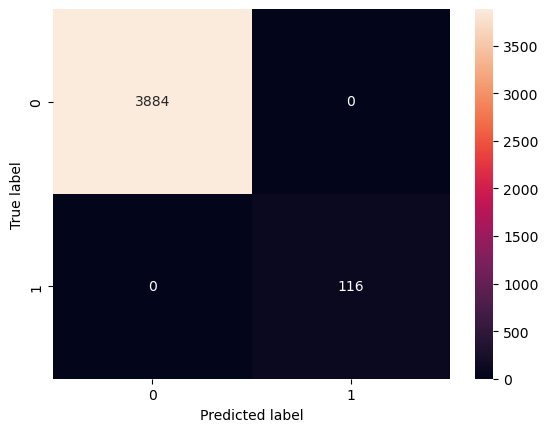

In [3]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Read datasets
attack_data = pd.read_csv('attack_points_123 (3).csv')
non_attack_data = pd.read_csv('non_attack_points_123 (3).csv')

# Label the data
attack_data['label'] = 'attack'
non_attack_data['label'] = 'nonattack'

# Combine the datasets
data = pd.concat([attack_data, non_attack_data], axis=0)

# Encode string labels into binary labels
data['label'] = data['label'].map({'attack': 1, 'nonattack': 0})

# Split into features and labels
X = data[['X1', 'X2', 'X3', 'X4', 'X5', 'd']]
y = data['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize an XGBoost Classifier and train
clf = XGBClassifier(n_estimators=10000, objective="binary:logistic", seed=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print(cm)

# Optional: Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score

# Read datasets
attack_data = pd.read_csv('attack_points_123 (3).csv')
non_attack_data = pd.read_csv('non_attack_points_123 (3).csv')

# Label the data
attack_data['label'] = 'attack'
non_attack_data['label'] = 'nonattack'

# Combine the datasets
data = pd.concat([attack_data, non_attack_data], axis=0)

# Encode string labels into binary labels
data['label'] = data['label'].map({'attack': 1, 'nonattack': 0})

# Split into features and labels
X = data[['X1', 'X2', 'X3', 'X4', 'X5']]
y = data['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize a CatBoost Classifier and train
clf = CatBoostClassifier(iterations=100000, verbose=500)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Learning rate set to 0.000493
0:	learn: 0.6913814	total: 201ms	remaining: 5h 35m 48s
500:	learn: 0.1800739	total: 2.59s	remaining: 8m 33s
1000:	learn: 0.0477050	total: 4.48s	remaining: 7m 23s
1500:	learn: 0.0161454	total: 6.38s	remaining: 6m 58s
2000:	learn: 0.0068528	total: 8.33s	remaining: 6m 48s
2500:	learn: 0.0035130	total: 10.3s	remaining: 6m 39s
3000:	learn: 0.0020826	total: 12.2s	remaining: 6m 34s
3500:	learn: 0.0013777	total: 14.1s	remaining: 6m 28s
4000:	learn: 0.0009900	total: 16.1s	remaining: 6m 27s
4500:	learn: 0.0007516	total: 18.1s	remaining: 6m 23s
5000:	learn: 0.0005973	total: 20.1s	remaining: 6m 22s
5500:	learn: 0.0004885	total: 22.2s	remaining: 6m 20s
6000:	learn: 0.0004107	total: 24.2s	remaining: 6m 19s
6500:	learn: 0.0003524	total: 26.3s	remaining: 6m 17s
7000:	learn: 0.0003079	total: 28.3s	remaining: 6m 16s
7500:	learn: 0.0002724	total: 30.3s	remaining: 6m 14s
8000:	learn: 0.0002440	total: 32.4s	remaining: 6m 12s
8500:	learn: 0.0002208	total: 34.5s	remaining: 6m 10

74000:	learn: 0.0000689	total: 4m 27s	remaining: 1m 33s
74500:	learn: 0.0000689	total: 4m 29s	remaining: 1m 32s
75000:	learn: 0.0000689	total: 4m 30s	remaining: 1m 30s
75500:	learn: 0.0000689	total: 4m 32s	remaining: 1m 28s
76000:	learn: 0.0000689	total: 4m 34s	remaining: 1m 26s
76500:	learn: 0.0000689	total: 4m 36s	remaining: 1m 24s
77000:	learn: 0.0000689	total: 4m 37s	remaining: 1m 22s
77500:	learn: 0.0000689	total: 4m 39s	remaining: 1m 21s
78000:	learn: 0.0000689	total: 4m 40s	remaining: 1m 19s
78500:	learn: 0.0000689	total: 4m 42s	remaining: 1m 17s
79000:	learn: 0.0000689	total: 4m 43s	remaining: 1m 15s
79500:	learn: 0.0000689	total: 4m 45s	remaining: 1m 13s
80000:	learn: 0.0000689	total: 4m 47s	remaining: 1m 11s
80500:	learn: 0.0000689	total: 4m 48s	remaining: 1m 9s
81000:	learn: 0.0000689	total: 4m 50s	remaining: 1m 8s
81500:	learn: 0.0000689	total: 4m 52s	remaining: 1m 6s
82000:	learn: 0.0000689	total: 4m 53s	remaining: 1m 4s
82500:	learn: 0.0000689	total: 4m 55s	remaining: 1m 

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score

# Read datasets
attack_data = pd.read_csv('attack_points_123 (3).csv')
non_attack_data = pd.read_csv('non_attack_points_123 (3).csv')

# Label the data
attack_data['label'] = 'attack'
non_attack_data['label'] = 'nonattack'

# Combine the datasets
data = pd.concat([attack_data, non_attack_data], axis=0)

# Encode string labels into binary labels
data['label'] = data['label'].map({'attack': 1, 'nonattack': 0})

# Split into features and labels
X = data[['X1', 'X2', 'X3', 'X4', 'X5', 'd']]
y = data['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a LightGBM classifier and train
clf = LGBMClassifier(n_estimators=1000, min_data_in_leaf=5, min_split_gain=0.01, max_depth=7, learning_rate=0.05, class_weight='balanced')
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


AttributeError: module 'pandas.core.strings' has no attribute 'StringMethods'

In [4]:
pip install tpot

  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11952 sha256=4a47b322c01c38242fe7896d314440f366feac967ae1d666efce38abe2f3daa8
  Stored in directory: c:\users\aes21009\appdata\local\pip\cache\wheels\48\8c\93\3afb1916772591fe6bcc25cdf8b1c5bdc362f0ec8e2f0fd413
Successfully built stopit
Note: you may need to restart the kernel to use updated packages.


In [21]:
from tpot import TPOTClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Read datasets
attack_data = pd.read_csv('attack_points_123 (3).csv')
non_attack_data = pd.read_csv('non_attack_points_123 (3).csv')

# Label the data
attack_data['label'] = 'attack'
non_attack_data['label'] = 'nonattack'

# Combine the datasets
data = pd.concat([attack_data, non_attack_data], axis=0)

# Encode string labels into binary labels
data['label'] = data['label'].map({'attack': 1, 'nonattack': 0})

# Split into features and labels
X = data[['X1', 'X2', 'X3', 'X4', 'X5']]
y = data['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize TPOTClassifier and train
tpot = TPOTClassifier(verbosity=2, generations=5, population_size=20, random_state=42)
tpot.fit(X_train, y_train)

# Predictions
y_pred = tpot.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.96675

Generation 2 - Current best internal CV score: 0.9668125

Generation 3 - Current best internal CV score: 0.9669375

Generation 4 - Current best internal CV score: 0.9669375

Generation 5 - Current best internal CV score: 0.9669375

Best pipeline: DecisionTreeClassifier(input_matrix, criterion=gini, max_depth=5, min_samples_leaf=5, min_samples_split=4)
Accuracy: 0.97125
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3884
           1       0.57      0.03      0.07       116

    accuracy                           0.97      4000
   macro avg       0.77      0.52      0.53      4000
weighted avg       0.96      0.97      0.96      4000



In [2]:
pip install mljar-supervised

  Using cached mljar_supervised-1.1.1-py3-none-any.whl
  Using cached optuna-3.3.0-py3-none-any.whl (404 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
  Using cached category_encoders-2.6.2-py2.py3-none-any.whl (81 kB)
  Using cached dtreeviz-2.2.2-py3-none-any.whl (91 kB)
  Using cached scikit_plot-0.3.7-py3-none-any.whl (33 kB)
  Using cached wordcloud-1.9.2-cp39-cp39-win_amd64.whl (153 kB)
  Using cached shap-0.43.0-cp39-cp39-win_amd64.whl (447 kB)
  Using cached colour-0.1.5-py2.py3-none-any.whl (23 kB)
  Using cached cmaes-0.10.0-py3-none-any.whl (29 kB)
  Using cached colorlog-6.7.0-py2.py3-none-any.whl (11 kB)
  Using cached alembic-1.12.0-py3-none-any.whl (226 kB)
  Using cached Mako-1.2.4-py3-none-any.whl (78 kB)
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)
  Using cached numba-0.58.0-cp39-cp39-win_amd64.whl (2.6 MB)
  Using cached llvmlite-0.41.0-cp39-cp39-win_amd64.whl (28.1 MB)
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0

ERROR: Cannot uninstall 'llvmlite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML
from sklearn.metrics import classification_report, accuracy_score

# Read datasets
attack_data = pd.read_csv('attack_points_123 (2).csv')
non_attack_data = pd.read_csv('non_attack_points_123 (2).csv')

# Label the data
attack_data['label'] = 1
non_attack_data['label'] = 0

# Combine the datasets
data = pd.concat([attack_data, non_attack_data], axis=0)

# Split into features and labels
X = data[['X1', 'X2', 'X3', 'X4', 'X5', 'd']]
y = data['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize AutoML and train
automl = AutoML(mode="Compete", eval_metric="accuracy")
automl.fit(X_train, y_train)

# Predictions
y_pred = automl.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


ModuleNotFoundError: No module named 'supervised'

In [4]:
pip install H2O

  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
  Created wheel for H2O: filename=h2o-3.42.0.4-py2.py3-none-any.whl size=240946595 sha256=66d3a0c343f2acfe92545474c04153ef7445439e3951eee16822401f9160df7b
  Stored in directory: c:\users\aes21009\appdata\local\pip\cache\wheels\12\cf\48\bf3211d6e902af21f5ba8a26add1930362c37c956f1597ae4e
Successfully built H2O
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install auto-sklearn


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
  Created wheel for auto-sklearn: filename=auto_sklearn-0.3.0-cp39-cp39-win_amd64.whl size=3596203 sha256=e516c8e44b6a6b830a1d87c88cbe2ee9fc8ae04e24541eb799b2dab82752de4b
  Stored in directory: c:\users\aes21009\appdata\local\pip\cache\wheels\a7\1f\9b\c6187e1aa73ff4e982008b61fc207b553939ccfd975c3ed533
  Created wheel for pynisher: filename=pynisher-0.4.2-py3-none-any.whl size=4218 sha256=3a4fc9004dc5ccac5b3ee72e7c5eb5e18fe89e0456d44bafd5d9db331ac9fc3f
  Stored in directory: c:\users\aes21009\appdata\local\pip\cache\wheels\aa\f5\90\bdee2c395e95702a631a8b2bc835fdaccb0cf333e0599b1d26
  Running setup.py clean for pyrfr
  Running setup.py clean for scikit-learn
  Created wheel for smac: filename=smac-0.8.0-py3-none-any.whl size=97295 sha256=7a1e58341293357a4e53740a1a5acb4ae3c4f

  ERROR: Command errored out with exit status 1:
   command: 'C:\ProgramData\Anaconda3\python.exe' 'C:\ProgramData\Anaconda3\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py' get_requires_for_build_wheel 'C:\Users\aes21009\AppData\Local\Temp\tmpi3vka9x8'
       cwd: C:\Users\aes21009\AppData\Local\Temp\pip-install-xvhein6k\auto-sklearn_1209fe74b18f4ccc9caef8eaaf6d1210
  Complete output (17 lines):
  Traceback (most recent call last):
    File "C:\ProgramData\Anaconda3\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py", line 349, in <module>
      main()
    File "C:\ProgramData\Anaconda3\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py", line 331, in main
      json_out['return_val'] = hook(**hook_input['kwargs'])
    File "C:\ProgramData\Anaconda3\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py", line 117, in get_requires_for_build_wheel
      return hook(config_settings)
    File "C:\Users\aes21009\AppData\Local\Temp\pip-build-e

        raise ValueError(
    ValueError: Detected unsupported operating system: win32. Please check the compability information of auto-sklearn: http://automl.github.io/auto-sklearn/stable/installation.html#windows-osx-compability
    ----------------------------------------
    ERROR: Command errored out with exit status 1:
     command: 'C:\ProgramData\Anaconda3\python.exe' -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\aes21009\\AppData\\Local\\Temp\\pip-install-xvhein6k\\auto-sklearn_47267715d26d4a0598b5d83b17403019\\setup.py'"'"'; __file__='"'"'C:\\Users\\aes21009\\AppData\\Local\\Temp\\pip-install-xvhein6k\\auto-sklearn_47267715d26d4a0598b5d83b17403019\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users

In [13]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Read datasets
attack_data = pd.read_csv('attack_points_123 (3).csv')
non_attack_data = pd.read_csv('non_attack_points_123 (3).csv')

# Label the data
attack_data['label'] = 'attack'
non_attack_data['label'] = 'nonattack'

# Combine the datasets
data = pd.concat([attack_data, non_attack_data], axis=0)

# Encode string labels into binary labels
data['label'] = data['label'].map({'attack': 1, 'nonattack': 0})

# Split into features and labels
X = data[['X1', 'X2', 'X3', 'X4', 'X5','d']]
y = data['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

h2o_train['label'] = h2o_train['label'].asfactor()
h2o_test['label'] = h2o_test['label'].asfactor()

# Initialize H2O and autoML
h2o.init()
h2o_aml = H2OAutoML(max_runtime_secs = 3600)
h2o_train = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))
h2o_test = h2o.H2OFrame(pd.concat([X_test, y_test], axis=1))
h2o_aml.train(y="label", training_frame=h2o_train)

# Predictions
y_pred = h2o_aml.predict(h2o_test).as_data_frame()['predict'].values

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 hours 5 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.4
H2O_cluster_version_age:,9 days
H2O_cluster_name:,H2O_from_python_aes21009_0yiwuc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.365 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
07:30:15.141: AutoML: XGBoost is not available; skipping it.
07:30:15.142: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
07:30:15.672: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

██
07:30:22.86: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
07:30:22.213: _response param,

H2OJobCancelled: Job<$03017f00000132d4ffffffff$_93150154403936676ff2215770444d07> was cancelled by the user.

In [7]:
import autosklearn.classification
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Read datasets
attack_data = pd.read_csv('attack_points_123 (2).csv')
non_attack_data = pd.read_csv('non_attack_points_123 (2).csv')

# Label the data
attack_data['label'] = 1
non_attack_data['label'] = 0

# Combine the datasets
data = pd.concat([attack_data, non_attack_data], axis=0)

# Split into features and labels
X = data[['X1', 'X2', 'X3', 'X4', 'X5', 'd']]
y = data['label']

# Initialize auto-sklearn classifier and train
clf = autosklearn.classification.AutoSklearnClassifier()
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


ModuleNotFoundError: No module named 'autosklearn'

Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1135
           1       0.98      0.98      0.98      2865

    accuracy                           0.97      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.97      0.97      0.97      4000

[[1082   53]
 [  67 2798]]


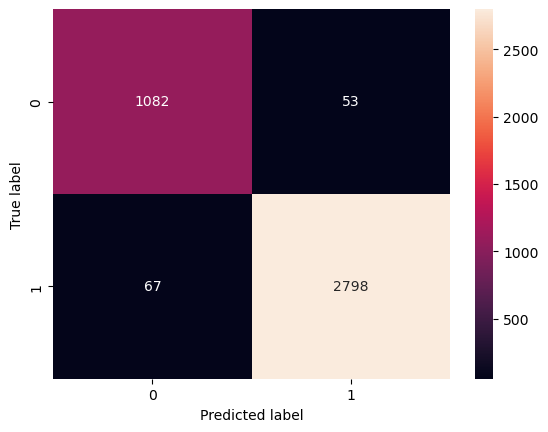

In [19]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Read datasets
attack_data = pd.read_csv('attack_points_aspen_1.csv')
non_attack_data = pd.read_csv('non_attack_points_aspen_1.csv')

# Label the data
attack_data['label'] = 'attack'
non_attack_data['label'] = 'nonattack'

# Combine the datasets
data = pd.concat([attack_data, non_attack_data], axis=0)

# Encode string labels into binary labels
data['label'] = data['label'].map({'attack': 1, 'nonattack': 0})

# Split into features and labels
X = data[['X1', 'X2', 'X3', 'X4', 'X5', 'X6']]
y = data['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize an XGBoost Classifier and train
clf = XGBClassifier(n_estimators=10000, objective="binary:logistic", seed=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print(cm)

# Optional: Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('class1.png')
plt.show()

Accuracy: 0.99925
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1135
           1       1.00      1.00      1.00      2865

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

[[1134    1]
 [   2 2863]]


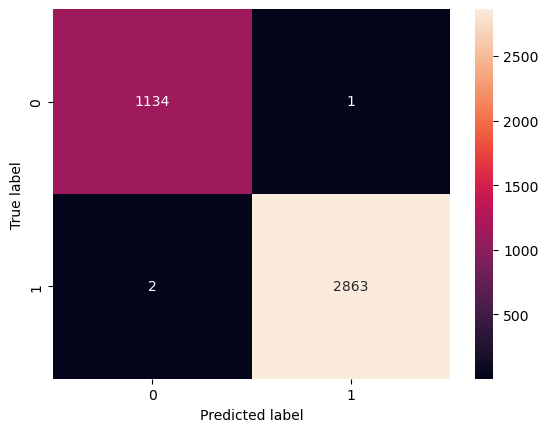

In [18]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Read datasets
attack_data = pd.read_csv('attack_points_aspen_1.csv')
non_attack_data = pd.read_csv('non_attack_points_aspen_1.csv')

# Label the data
attack_data['label'] = 'attack'
non_attack_data['label'] = 'nonattack'

# Combine the datasets
data = pd.concat([attack_data, non_attack_data], axis=0)

# Encode string labels into binary labels
data['label'] = data['label'].map({'attack': 1, 'nonattack': 0})

# Split into features and labels
X = data[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'd', 'vv']]
y = data['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize an XGBoost Classifier and train
clf = XGBClassifier(n_estimators=10000, objective="binary:logistic", seed=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print(cm)

# Optional: Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('class2.png')
plt.show()

Accuracy: 0.96925
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1135
           1       0.98      0.98      0.98      2865

    accuracy                           0.97      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.97      0.97      0.97      4000

[[1080   55]
 [  68 2797]]


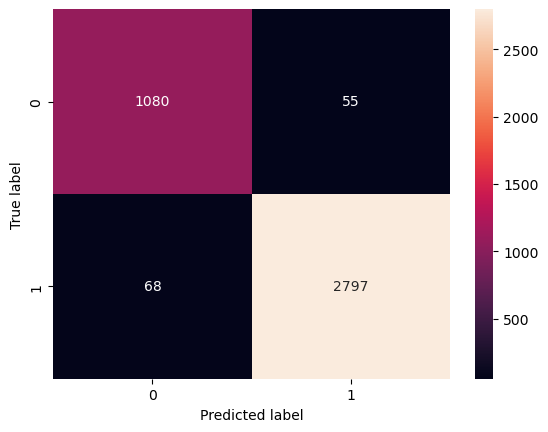

In [20]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Read datasets
attack_data = pd.read_csv('attack_points_aspen_1.csv')
non_attack_data = pd.read_csv('non_attack_points_aspen_1.csv')

# Label the data
attack_data['label'] = 'attack'
non_attack_data['label'] = 'nonattack'

# Combine the datasets
data = pd.concat([attack_data, non_attack_data], axis=0)

# Encode string labels into binary labels
data['label'] = data['label'].map({'attack': 1, 'nonattack': 0})

# Split into features and labels
X = data[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'd']]
y = data['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize an XGBoost Classifier and train
clf = XGBClassifier(n_estimators=10000, objective="binary:logistic", seed=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print(cm)

# Optional: Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('class3.png')
plt.show()

Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     19308
           1       0.38      0.25      0.31       692

    accuracy                           0.96     20000
   macro avg       0.68      0.62      0.64     20000
weighted avg       0.95      0.96      0.96     20000

[[19024   284]
 [  516   176]]


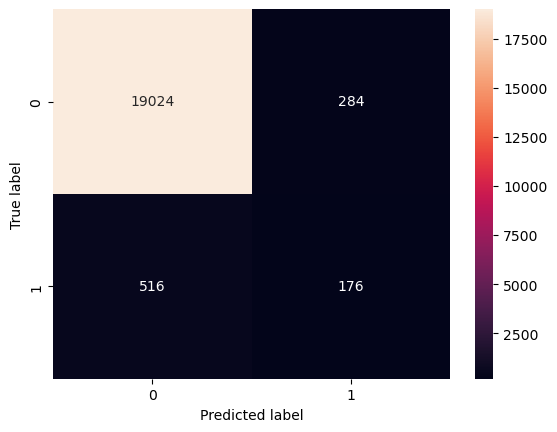

In [136]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Read datasets
attack_data = pd.read_csv('attack_points_123_Final.csv')
non_attack_data = pd.read_csv('non_attack_points_123_Final.csv')

# Label the data
attack_data['label'] = 'attack'
non_attack_data['label'] = 'nonattack'

# Combine the datasets
data = pd.concat([attack_data, non_attack_data], axis=0)

# Encode string labels into binary labels
data['label'] = data['label'].map({'attack': 1, 'nonattack': 0})

# Split into features and labels
X = data[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'd']]
y = data['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize an XGBoost Classifier and train
clf = XGBClassifier(n_estimators=10000, objective="binary:logistic", seed=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print(cm)

# Optional: Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('class3.png')
plt.show()

In [137]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.utils import class_weight

# Read datasets
attack_data = pd.read_csv('attack_points_123_Final.csv')
non_attack_data = pd.read_csv('non_attack_points_123_Final.csv')

# Label the data
attack_data['label'] = 1  # attack
non_attack_data['label'] = 0  # nonattack

# Combine the datasets
data = pd.concat([attack_data, non_attack_data], axis=0)

# Split into features and labels
X = data[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'd']]
y = data['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate the class weights
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weight_dict = {i: weights[i] for i in range(len(weights))}

# Initialize an XGBoost Classifier with scale_pos_weight parameter to handle imbalance
clf = XGBClassifier(n_estimators=1000, objective="binary:logistic", seed=42, scale_pos_weight=weights[1])

# Train the classifier
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate the model
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F-Score: {fscore}")


Precision: 0.36470588235294116
Recall: 0.4031791907514451
F-Score: 0.3829787234042553


In [10]:
import os
os.listdir('.')


['Aspen_D1_Sub_D1__D7_6_D8__VLN.Txt',
 'attack_points_aspen.csv',
 'Breaker.dss',
 'Breaker_control.dss',
 'CNData.dss',
 'DER_Information',
 'DER_Shape.dss',
 'DER_Shape_1min.dss',
 'DER_Shape_2019_new.dss',
 'DER_Shape_2019_new_1min.dss',
 'DER_Shape_2020.dss',
 'Device.dss',
 'Device_other.dss',
 'ES_2019_new.dss',
 'ES_Control_2019_new.dss',
 'EV',
 'EV_2020',
 'EV_min',
 'Ev_qsts_2019.dss',
 'Ev_Shape_2019.dss',
 'Ev_Shape_2019_1min.dss',
 'Fuse.dss',
 'Fuse_control.dss',
 'Generator_qsts.dss',
 'Generator_qsts_2020.dss',
 'Gen_qsts_2019_new_zne.dss',
 'GS',
 'GS_2020',
 'GS_min',
 'Line.dss',
 'LineGeometry.dss',
 'Line_full.dss',
 'LoadShape.dss',
 'LoadShape_1min.dss',
 'LoadShape_2020.dss',
 'Loads_qsts.dss',
 'Loads_qsts_2020.dss',
 'LS',
 'LS_2020',
 'LS_min',
 'Master_qsts.dss',
 'Master_qsts_1min.dss',
 'Master_qsts_2020.dss',
 'nodecoords.csv',
 'non_attack_points_aspen.csv',
 'Reactor.dss',
 'Recloser.dss',
 'Recloser_control.dss',
 'RegControl.dss',
 'Script Window 6.ds

In [3]:
import csv

# Initial values
initial_values = {
    'X1': 0.5, 'X2': 0.92, 'X3': 0.95, 'X4': 1.0, 'X5': 1.08, 'X6': 1.5
}

# Function to convert changes to text commands
def changes_to_text_commands(changes):
    commands = []
    for key, change in changes.items():
        direction = 'left' if change < 0 else 'right'
        command = f"Shift {key} {direction} by {abs(change):.3f} units"
        commands.append(command)
    return ', '.join(commands)

# Reading the CSV and converting to text commands
with open('attack_points_aspen_1.csv', 'r') as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        changes = {key: float(row[key]) - initial_values[key] for key in initial_values}
        text_commands = changes_to_text_commands(changes)
        label = row['label']
        print(f"Round {row['Round']}: {text_commands}, Label: {label}")


Round 0: Shift X1 right by 0.049 units, Shift X2 left by 0.100 units, Shift X3 left by 0.100 units, Shift X4 left by 0.070 units, Shift X5 right by 0.005 units, Shift X6 left by 0.019 units, Label: 1
Round 1: Shift X1 left by 0.021 units, Shift X2 left by 0.100 units, Shift X3 left by 0.042 units, Shift X4 left by 0.082 units, Shift X5 left by 0.100 units, Shift X6 left by 0.100 units, Label: 1
Round 5: Shift X1 left by 0.052 units, Shift X2 left by 0.060 units, Shift X3 left by 0.060 units, Shift X4 left by 0.098 units, Shift X5 left by 0.042 units, Shift X6 left by 0.027 units, Label: 1
Round 6: Shift X1 left by 0.100 units, Shift X2 right by 0.077 units, Shift X3 right by 0.057 units, Shift X4 right by 0.080 units, Shift X5 right by 0.010 units, Shift X6 left by 0.058 units, Label: 1
Round 7: Shift X1 left by 0.100 units, Shift X2 left by 0.100 units, Shift X3 left by 0.100 units, Shift X4 left by 0.076 units, Shift X5 right by 0.026 units, Shift X6 left by 0.100 units, Label: 1
Rou

In [146]:
import csv

# Initial values
initial_values = {
    'X1': 0.5, 'X2': 0.92, 'X3': 0.95, 'X4': 1.0, 'X5': 1.08, 'X6': 1.5
}

# Function to convert changes to text commands
def changes_to_text_commands(changes):
    commands = []
    for key, change in changes.items():
        direction = 'left' if change < 0 else 'right'
        command = f"Shift {key} {direction} by {abs(change):.3f} units"
        commands.append(command)
    return ', '.join(commands)

# Reading the CSV and converting to text commands
with open('attack_points_123_Final_for_LLM.csv', 'r') as file, open('converted_data_123_final.csv', 'w', newline='') as outfile:
    csv_reader = csv.DictReader(file)
    csv_writer = csv.writer(outfile)
    csv_writer.writerow(['Text', 'Label'])  # Writing header for the new CSV file

    for row in csv_reader:
        changes = {key: float(row[key]) - initial_values[key] for key in initial_values}
        text_commands = changes_to_text_commands(changes)
        label = row['label']
        csv_writer.writerow([text_commands, label])  # Writing to the new CSV file

print("Conversion complete. Data saved in 'converted_data_123_final.csv'")


Conversion complete. Data saved in 'converted_data_123_final.csv'


In [5]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install peft

  Obtaining dependency information for peft from https://files.pythonhosted.org/packages/d0/a6/c5442d9172fae3554f8d83699a1c05015152f7c84fef934eeb81cbfec4f8/peft-0.6.1-py3-none-any.whl.metadata
  Obtaining dependency information for torch>=1.13.0 from https://files.pythonhosted.org/packages/74/07/edce54779f5c3fe8ab8390eafad3d7c8190fce68f922a254ea77f4a94a99/torch-2.1.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for accelerate>=0.21.0 from https://files.pythonhosted.org/packages/13/9e/ee987874058f2d93006961f6ff49e0bcb60ab9c26709ebe06bfa8707a4d8/accelerate-0.24.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/136.0 kB ? eta -:--:--
   ---------------------------------------- 136.0/136.0 kB 7.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/261.4 kB ? eta -:--:--
   --------------------------------------- 261.4/261.4 kB 16.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/192.3 MB ? eta -:--:--
   -----

In [8]:
pip install evaluate

  Obtaining dependency information for evaluate from https://files.pythonhosted.org/packages/70/63/7644a1eb7b0297e585a6adec98ed9e575309bb973c33b394dae66bc35c69/evaluate-0.4.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/84.1 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/84.1 kB ? eta -:--:--
   ---------------------------------------- 84.1/84.1 kB 1.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [236]:
from datasets import load_dataset, DatasetDict, Dataset

from transformers import (
    AutoTokenizer,
    AutoConfig, 
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate
import torch
import numpy as np

In [237]:
# load dataset
dataset = load_dataset("AlaaSelim/Cyberattackdetectioncommands")
dataset

Found cached dataset csv (C:/Users/AES21009/.cache/huggingface/datasets/AlaaSelim___csv/AlaaSelim--Cyberattackdetectioncommands-679643674eed08f9/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 4000
    })
})

In [238]:
# display % of training data with label=1
np.array(dataset['train']['label']).sum()/len(dataset['train']['label'])

0.711

In [239]:
model_checkpoint = 'distilbert-base-uncased'
# model_checkpoint = 'roberta-base' # you can alternatively use roberta-base but this model is bigger thus training will take longer

# define label maps
id2label = {0: "Negative", 1: "Positive"}
label2id = {"Negative":0, "Positive":1}

# generate classification model from model_checkpoint
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=2, id2label=id2label, label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [240]:
# display architecture
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [241]:
# create tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

# add pad token if none exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

In [242]:
# create tokenize function
def tokenize_function(examples):
    # extract text
    text = examples["text"]

    #tokenize and truncate text
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        truncation=True,
        max_length=512
    )

    return tokenized_inputs

In [243]:
# tokenize training and validation datasets
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset

Loading cached processed dataset at C:\Users\AES21009\.cache\huggingface\datasets\AlaaSelim___csv\AlaaSelim--Cyberattackdetectioncommands-679643674eed08f9\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-1e4d593aaf0f55b3.arrow
Loading cached processed dataset at C:\Users\AES21009\.cache\huggingface\datasets\AlaaSelim___csv\AlaaSelim--Cyberattackdetectioncommands-679643674eed08f9\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-afa5cde014c902d1.arrow


DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 4000
    })
})

In [244]:
# create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [245]:
# import accuracy evaluation metric
accuracy = evaluate.load("accuracy")

In [246]:
from evaluate import load
precision_metric = load("precision")


In [247]:
# define an evaluation function to pass into trainer later
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {"accuracy": accuracy.compute(predictions=predictions, references=labels)}

In [248]:
from evaluate import load
import numpy as np

# Load the precision metric outside the function
precision_metric = load('precision')

# Define an evaluation function to pass into the trainer
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    
    # Calculate precision using the loaded precision_metric
    precision_result = precision_metric.compute(predictions=predictions, references=labels)
    
    # Return the precision result
    return {"precision": precision_result["precision"]}


In [249]:
# define list of examples
text_list = ["Shift X1 right by 0.049 units, Shift X2 left by 0.100 units, Shift X3 left by 0.100 units, Shift X4 left by 0.070 units, Shift X5 right by 0.005 units, Shift X6 left by 0.019 units", "Shift X1 left by 0.100 units, Shift X2 left by 0.080 units, Shift X3 left by 0.060 units, Shift X4 right by 0.039 units, Shift X5 right by 0.023 units, Shift X6 left by 0.059 units"]

print("Untrained model predictions:")
print("----------------------------")
for text in text_list:
    # tokenize text
    inputs = tokenizer.encode(text, return_tensors="pt")
    # compute logits
    logits = model(inputs).logits
    # convert logits to label
    predictions = torch.argmax(logits)

    print(text + " - " + id2label[predictions.tolist()])

Untrained model predictions:
----------------------------
Shift X1 right by 0.049 units, Shift X2 left by 0.100 units, Shift X3 left by 0.100 units, Shift X4 left by 0.070 units, Shift X5 right by 0.005 units, Shift X6 left by 0.019 units - Negative
Shift X1 left by 0.100 units, Shift X2 left by 0.080 units, Shift X3 left by 0.060 units, Shift X4 right by 0.039 units, Shift X5 right by 0.023 units, Shift X6 left by 0.059 units - Negative


In [250]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                        r=8,
                        lora_alpha=32,
                        lora_dropout=0.05,
                        target_modules = ['q_lin'])

In [251]:
peft_config


LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, r=8, target_modules={'q_lin'}, lora_alpha=32, lora_dropout=0.05, fan_in_fan_out=False, bias='none', modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={})

In [252]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 665,858 || all params: 67,620,868 || trainable%: 0.9846930684178736


In [256]:
# hyperparameters
lr = 1e-3
batch_size = 4
num_epochs = 10

In [257]:
# define training arguments
training_args = TrainingArguments(
    output_dir= model_checkpoint + "-lora-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [258]:
# creater trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator, # this will dynamically pad examples in each batch to be equal length
    compute_metrics=compute_metrics,
)

# train model
trainer.train()

Epoch,Training Loss,Validation Loss,Precision
1,0.331600,0.455767,0.882093
2,0.340200,0.268582,0.956351
3,0.365200,0.296865,0.958496
4,0.375400,0.478201,0.967243
5,0.390100,0.306783,0.930663
6,0.373000,0.237368,0.954035
7,0.316400,0.248139,0.957057
8,0.268200,0.304375,0.939062
9,0.282100,0.263347,0.957514
10,0.269900,0.236313,0.958158


TrainOutput(global_step=40000, training_loss=0.3491558946609497, metrics={'train_runtime': 12265.2225, 'train_samples_per_second': 13.045, 'train_steps_per_second': 3.261, 'total_flos': 2765984855936640.0, 'train_loss': 0.3491558946609497, 'epoch': 10.0})

In [260]:
print(tokenized_dataset.keys())


dict_keys(['train', 'validation'])


In [261]:
split_dataset = dataset["train"].train_test_split(test_size=0.2)
train_dataset = split_dataset["train"]
validation_dataset = split_dataset["test"]


In [262]:
train_dataset.to_csv("train_dataset.csv")
validation_dataset.to_csv("validation_dataset.csv")


Creating CSV from Arrow format:   0%|          | 0/13 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

592642

In [263]:
model.to('cpu') # moving to mps for Mac (can alternatively do 'cpu')

print("Trained model predictions:")
print("--------------------------")
for text in text_list:
    inputs = tokenizer.encode(text, return_tensors="pt").to("cpu") # moving to mps for Mac (can alternatively do 'cpu')

    logits = model(inputs).logits
    predictions = torch.max(logits,1).indices

    print(text + " - " + id2label[predictions.tolist()[0]])

Trained model predictions:
--------------------------
Shift X1 right by 0.049 units, Shift X2 left by 0.100 units, Shift X3 left by 0.100 units, Shift X4 left by 0.070 units, Shift X5 right by 0.005 units, Shift X6 left by 0.019 units - Positive
Shift X1 left by 0.100 units, Shift X2 left by 0.080 units, Shift X3 left by 0.060 units, Shift X4 right by 0.039 units, Shift X5 right by 0.023 units, Shift X6 left by 0.059 units - Negative


In [147]:
import pandas as pd
df = pd.read_csv('converted_data_123_final.csv')
from sklearn.model_selection import train_test_split

# Assume you want to split the data into 80% training and 20% validation
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.to_csv('train_data_123.csv', index=False)
val_df.to_csv('validation_data_123.csv', index=False)


In [ ]:
import socket

def process_data(data):
    # Process data using Python logic
    return processed_data

# Set up server to listen for connections
server_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
server_socket.bind(('0.0.0.0', port_number)) # Bind to IP and port
server_socket.listen()

while True:
    # Accept connection from RTAC
    client_socket, addr = server_socket.accept()

    # Receive data from RTAC
    data = client_socket.recv(buffer_size)
    processed_data = process_data(data)

    # Send processed data back to RTAC
    client_socket.send(processed_data)
    client_socket.close()


In [1]:
pip install tpot


  Obtaining dependency information for tpot from https://files.pythonhosted.org/packages/7b/a7/0060d028906ecd058b1331c3ce6f3f19ba03464b21dc9abbbaf66b0a1091/TPOT-0.12.1-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     ------------ --------------------------- 0.3/1.1 MB 4.1 MB/s eta 0:00:01
     ----------------------------------- ---- 0.9/1.1 MB 8.5 MB/s eta 0:00:01
     ---------------------------------------- 1.1/1.1 MB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/87.4 kB ? eta -:--:--
   ---------------------------------------- 87.4/87.4 kB 4.8 MB/s eta 0:00:00
  Created wheel for deap: filename=deap-1.4.1-cp311-cp311-win_amd64.whl size=1

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9701250000000001

Generation 2 - Current best internal CV score: 0.9703125

Generation 3 - Current best internal CV score: 0.9703125

Generation 4 - Current best internal CV score: 0.9706875

Generation 5 - Current best internal CV score: 0.9710625

Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=1.0, min_samples_leaf=12, min_samples_split=9, n_estimators=100)
Accuracy: 0.9745
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1135
           1       0.98      0.98      0.98      2865

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000

[[1092   43]
 [  59 2806]]


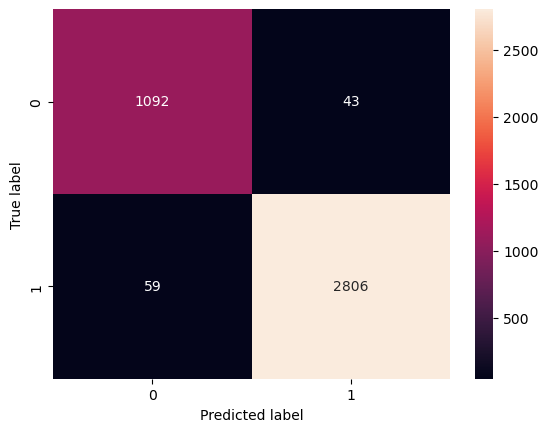

In [2]:
from tpot import TPOTClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Read datasets
attack_data = pd.read_csv('attack_points_aspen_1.csv')
non_attack_data = pd.read_csv('non_attack_points_aspen_1.csv')

# Label the data
attack_data['label'] = 'attack'
non_attack_data['label'] = 'nonattack'

# Combine the datasets
data = pd.concat([attack_data, non_attack_data], axis=0)

# Encode string labels into binary labels
data['label'] = data['label'].map({'attack': 1, 'nonattack': 0})

# Split into features and labels
X = data[['X1', 'X2', 'X3', 'X4', 'X5', 'X6']]
y = data['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize TPOT classifier
tpot = TPOTClassifier(generations=5, population_size=500, verbosity=2, random_state=42)

# Fit the model
tpot.fit(X_train, y_train)

# Predictions
y_pred = tpot.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print(cm)

# Optional: Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('class1_tpot.png')
plt.show()

# Optionally, export the pipeline code
tpot.export('tpot_pipeline.py')


Optimization Progress:   0%|          | 0/3000 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9748749999999999

Generation 2 - Current best internal CV score: 0.977375

Generation 3 - Current best internal CV score: 0.977375

Generation 4 - Current best internal CV score: 0.977375

Generation 5 - Current best internal CV score: 0.9780000000000001

Best pipeline: XGBClassifier(GaussianNB(MinMaxScaler(input_matrix)), learning_rate=0.1, max_depth=10, min_child_weight=8, n_estimators=100, n_jobs=1, subsample=0.7500000000000001, verbosity=0)
Accuracy: 0.98025
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1135
           1       0.99      0.98      0.99      2865

    accuracy                           0.98      4000
   macro avg       0.97      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000

[[1099   36]
 [  43 2822]]


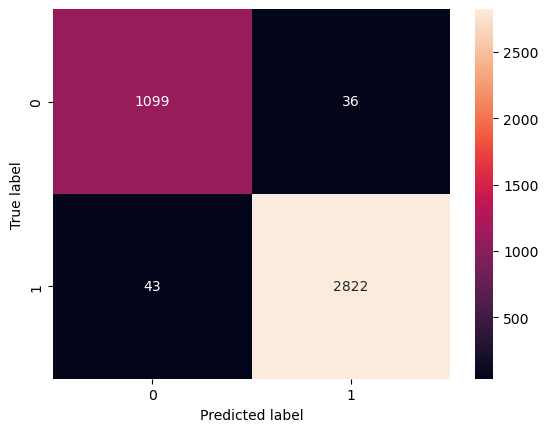

In [3]:
from tpot import TPOTClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Read datasets
attack_data = pd.read_csv('attack_points_aspen_1.csv')
non_attack_data = pd.read_csv('non_attack_points_aspen_1.csv')

# Label the data
attack_data['label'] = 'attack'
non_attack_data['label'] = 'nonattack'

# Combine the datasets
data = pd.concat([attack_data, non_attack_data], axis=0)

# Encode string labels into binary labels
data['label'] = data['label'].map({'attack': 1, 'nonattack': 0})

# Split into features and labels
X = data[['X1', 'X2', 'X3', 'X4', 'X5', 'X6']]
y = data['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize TPOT classifier
tpot = TPOTClassifier(generations=5, population_size=500, verbosity=2, random_state=42)

# Fit the model
tpot.fit(X_train, y_train)

# Predictions
y_pred = tpot.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print(cm)

# Optional: Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('class1_tpot.png')
plt.show()

# Optionally, export the pipeline code
tpot.export('tpot_pipeline.py')


In [ ]:
from tpot import TPOTClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Read datasets
attack_data = pd.read_csv('attack_points_aspen_1.csv')
non_attack_data = pd.read_csv('non_attack_points_aspen_1.csv')

# Label the data
attack_data['label'] = 'attack'
non_attack_data['label'] = 'nonattack'

# Combine the datasets
data = pd.concat([attack_data, non_attack_data], axis=0)

# Encode string labels into binary labels
data['label'] = data['label'].map({'attack': 1, 'nonattack': 0})

# Split into features and labels
X = data[['X1', 'X2', 'X3', 'X4', 'X5', 'X6']]
y = data['label']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize TPOT classifier
tpot = TPOTClassifier(generations=10, population_size=5000, verbosity=2, random_state=42)

# Fit the model
tpot.fit(X_train, y_train)

# Predictions
y_pred = tpot.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix
print(cm)

# Optional: Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('class1_tpot.png')
plt.show()

# Optionally, export the pipeline code
tpot.export('tpot_pipeline.py')


Optimization Progress:   0%|          | 0/55000 [00:00<?, ?pipeline/s]